<h2> Introduction </h2>

In this kernel, we will use Gausian Process Regressions and Bayesian Optimisation on ecoacoustic metrics to quantify the spatiotemporal distribution of birds on-farm. The data was obtained by placing 20 audio recorders across the property in a grid formation. The biodiversity project was set up in 14 and 15th Nov 2019.


<h2> Our Goals </h2>

<ul>
<li> Understand the spatial and temporal variability in the data, in particular, study how avian species richness change, examine if there are seasonal cycles.
<li> Determine the optimal placement of the 20 audio recorders using the previously described methods. </li>
<li> Determine what the optimal placement would be if one or more of the recorders were to stop functioning. </li>
</ul>


<h2> Outline </h2>

I. <b>Understanding our data</b><br>
a) [Gathering sense of our data](#gather)<br>

II. <b>Preprocessing</b><br>
a) [The PreProcessing Class](#preprocessing)<br>

III. <b>Modelling</b><br>
a) [The SingleFrameGaussianProcessModel Class](#singlegp)<br>
b) [The FullGaussianProcessModel Class](#fullgp)<br>
c) [The TSModel Class](#tsmodel)<br>


IV. <b>Visualizing </b><br>
a) [The Visualise Class](#visualise)<br>


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import statsmodels.api as sm
from itertools import product
from datetime import datetime

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

import warnings
warnings.filterwarnings("ignore")

<h2> II. Preprocessing </h2>
<a id="preprocessing"></a>

<h3>a) The PreProcessing Class</h3>

In [2]:
class PreProcessing:
    def __init__(self,data_name,metadata_name,data_type):
        self.instrument_data = pd.read_csv(data_name)
        self.instrument_metadata = pd.read_csv(metadata_name)
        self.names = np.unique(self.instrument_data['name'])
        self.formatted_data = self.format_data(data_type)
        self.current_data = self.formatted_data
        self.get_metadata()
        
    def get_metadata(self):
        metadata = self.instrument_metadata.set_index('instrument_name').sort_index()
        self.current_metadata = metadata.loc[self.names]
        return self.current_metadata
        
    def get_names(self):
        return list(self.current_data.columns)
    
    def get_single_frame_data(self,data,index):
        data = ecoacoustic_data.iloc[index]
        lats,longs = [],[]
        for name in preprocessor.names:
            lats.append(self.current_metadata['latitude'][name])
            longs.append(self.current_metadata['longitude'][name])

        single_frame_data = pd.DataFrame({'long':longs,'lat':lats,'val':data.values})
        
        return single_frame_data
    
    def get_single_site_data(self,data,name):
        return data[name]
        
    def format_data(self,data_type):
        diversity_index = self.instrument_data[self.instrument_data['type']==data_type]
        self.all_times = np.unique(diversity_index['timeStart'])
        
        grouped = diversity_index.groupby(['timeStart','name'], as_index=False).sum()
        grouped = grouped.drop('instrument_id', axis=1)
        pivoted = grouped.pivot(index="timeStart", columns="name").reset_index(drop=True)
        formatted_data = pivoted.droplevel(level=0, axis=1)
        formatted_data.columns.name = None
        formatted_data.fillna(0, inplace=True)

        return formatted_data
    
    def remove_plot(self):
#         This could be improved upon by looking at the intersections
        max_num_zeros = 0
        name_max_num_zeros = ''
        for name in self.names:
            num_zeros = (self.current_data[name]==0).sum()
            if num_zeros > max_num_zeros:
                max_num_zeros = num_zeros
                name_max_num_zeros = name
        self.current_data = self.current_data.drop(columns = [name_max_num_zeros])
        self.names = self.get_names()
        
    def get_sections(self,current_data,name):
        bool_zeros = current_data[:][name].values==0
        toggle = 2
        toggle_array=[]
        non_zero_sections = []
        zero_sections = []
        for i in range(bool_zeros.size):
            if toggle!=bool_zeros[i]:
                toggle = bool_zeros[i]
                toggle_array.append(i)
                if toggle and len(toggle_array)>1:
                    non_zero_sections.append([toggle_array[-2],i])
                elif not toggle and len(toggle_array)>2:
                    zero_sections.append([toggle_array[-2],toggle_array[-1]])
            if i == bool_zeros.size-1:
                if toggle:
                    zero_sections.append([toggle_array[-1],i])
                else:
                    non_zero_sections.append([toggle_array[-1],i])

        return non_zero_sections,zero_sections

    def get_overlapping_intersections(self,current_data):
        all_non_zero_sections = []
        for name in self.names:
            _,zero_sections = self.get_sections(current_data,name)
            for i in range(len(zero_sections)):
                len_section = zero_sections[i][1]-zero_sections[i][0] + 1
                if len_section < 20:
                    self.current_data[name][zero_sections[i][0]:zero_sections[i][1]] = np.nan

            non_zero_sections,_ = self.get_sections(current_data,name)
            all_non_zero_sections.append(non_zero_sections)           
        intersections = self.get_intersections(all_non_zero_sections)
        return intersections

    def get_intersection(self,range_1,range_2):
        x = range(range_1[0],range_1[1])
        y = range(range_2[0],range_2[1])
        xs = set(x)
        inter = xs.intersection(y)
        if len(inter) == 0:
            return []
        return [min(list(inter)),max(list(inter))+1]

    def get_intersections(self,all_non_zero_sections):
        final_set = []
        for i in range(len(all_non_zero_sections[0])):
            base_set = [all_non_zero_sections[0][i]]
            if len(all_non_zero_sections)>1:
                for j in range(1,len(all_non_zero_sections)):
                    new_set = []
                    # Loop over values in base_set
                    for k in range(len(base_set)):
                        # Loop over values in each section
                        for l in range(len(all_non_zero_sections[j])):
                            inter = self.get_intersection(base_set[k],all_non_zero_sections[j][l])
                            if len(inter) != 0:
                                new_set.append(inter)
                    base_set = new_set
            for b_set in base_set:
                final_set.append(b_set)
        return final_set
    
    def get_current_cleaned_data(self):
        ranges = self.get_overlapping_intersections(self.current_data)
        diff_r = []
        for r in ranges:
            diff_r.append(r[1]-r[0])
        max_range_idx = np.argmax(diff_r)
        cleaned_data = self.current_data.iloc[ranges[max_range_idx][0]:ranges[max_range_idx][1]]
        cleaned_and_interpolated_data = self.interpolate_data(cleaned_data)
        self.current_cleaned_data = cleaned_data
        
        cleaned_data['time'] = self.all_times[ranges[max_range_idx][0]:ranges[max_range_idx][1]]
        cleaned_data = cleaned_data.set_index('time')

        return cleaned_data
    
    def interpolate_data(self,data):
        for name in self.names:
            data[name] = data[name].interpolate()
        return data
    
    def get_current_cleaned_date_data(self,df):
        df = df.reset_index()
        df['time'] = df['time'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
        df['time'] = df.time.dt.date
        self.current_cleaned_date_data = df.groupby('time', as_index=False).mean()
        return self.current_cleaned_date_data
    
    def get_av_period(self,df):
        df = df.reset_index()
        df['time'] = df['time'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
        df['time'] = df.time.dt.date
        df = df.groupby('time', as_index=False).count()
        df = df['A01']
        return int(np.round(np.mean(df.values),0))

In [3]:
preprocessor = PreProcessing('data/instrument_data.csv','data/instrument_metadata.csv','ADI')
preprocessor.remove_plot()
metadata = preprocessor.get_metadata()
ecoacoustic_data = preprocessor.get_current_cleaned_data()
ecoacoustic_date_data = preprocessor.get_current_cleaned_date_data(ecoacoustic_data)
period = preprocessor.get_av_period(ecoacoustic_data)

<h2> III. Modelling </h2>
<a id="singlegp"></a>

<h3>a) The SingleFrameGaussianProcessModel Class</h3>

<a id="fullgp"></a>
<h3>b) The FullGaussianProcessModel Class</h3>

<a id="tsmodel"></a>
<h3>c) The TSModel Class</h3>

In [4]:
class EcoacousticModel:
    def __init__(self):
        print('Initializing Model')
        
#     def save_results

class SingleFrameGaussianProcessModel(EcoacousticModel):   
    def __init__(self, single_frame_data,n_points = 100):
#         filename = 
        super().__init__()
        self.n_points = n_points

        self.X = single_frame_data[['long','lat']].values
        self.y = single_frame_data.val.values

        # Input space
        x1 = np.linspace(np.min(single_frame_data.long), np.max(single_frame_data.long),n_points) #p
        x2 = np.linspace(np.min(single_frame_data.lat), np.max(single_frame_data.lat),n_points) #q
        self.x = (np.array([x1, x2])).T
        self.x1x2 = np.array(list(product(x1, x2)))
        self.X0p, self.X1p = self.x1x2[:,0].reshape(n_points,n_points), self.x1x2[:,1].reshape(n_points,n_points)


        kernel = C(1.0, (1e-3, 1e3)) * RBF([5,5], (1e-2, 1e2))
        self.gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15)

    def run(self):
        self.gp.fit(self.X, self.y)

        self.y_pred, self.MSE = self.gp.predict(self.x1x2, return_std=True)

        self.y_lower = self.y_pred - 2*self.MSE
        self.y_higher = self.y_pred + 2*self.MSE

        Zp_mean = np.reshape(self.y_pred,(self.n_points,self.n_points))
        Zp_lower = np.reshape(self.y_lower,(self.n_points,self.n_points))
        Zp_higher = np.reshape(self.y_higher,(self.n_points,self.n_points))

        self.vmin = np.min(self.y_lower)
        self.vmax = np.max(self.y_higher)

        fig, ax = plt.subplots(1,3,figsize=(20,4))

        ax[1].pcolormesh(self.X0p, self.X1p, Zp_mean,vmin=self.vmin,vmax=self.vmax,cmap='RdBu_r')
        ax[0].pcolormesh(self.X0p, self.X1p, Zp_lower,vmin=self.vmin,vmax=self.vmax,cmap='RdBu_r')
        ax[2].pcolormesh(self.X0p, self.X1p, Zp_higher,vmin=self.vmin,vmax=self.vmax,cmap='RdBu_r')

        plt.show()
        
class FullGaussianProcessModel(EcoacousticModel): 
#         filename = 
    def __init__(self, ecoacoustic_data):
        super().__init__()
        self.ecoacoustic_data = ecoacoustic_data
        self.names = list(ecoacoustic_data.columns)
        
class TSModel(EcoacousticModel): 
#         filename = 
    def __init__(self, single_site_data, period):
        super().__init__() 
        self.period = period
        
        self.single_site_data = single_site_data
        self.seasonal_decompose(self.single_site_data)
        
    def seasonal_decompose(self,data):
        decomposition = sm.tsa.seasonal_decompose(data.values, model='additive',extrapolate_trend='freq',period=self.period)
        fig = decomposition.plot()
        fig.set_size_inches(14,7)
        plt.show()

Initializing Model


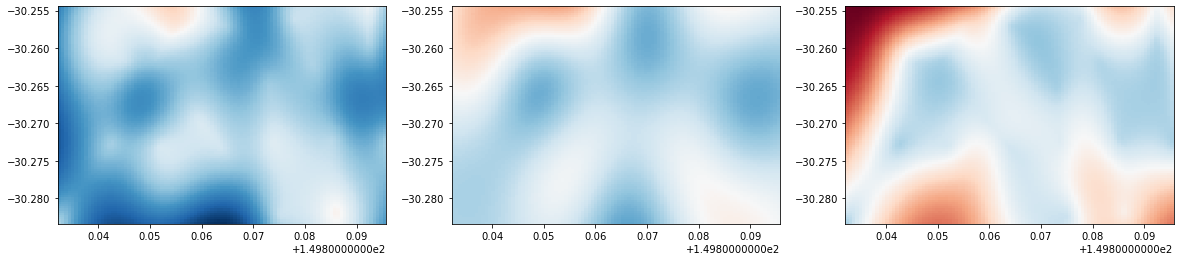

Initializing Model


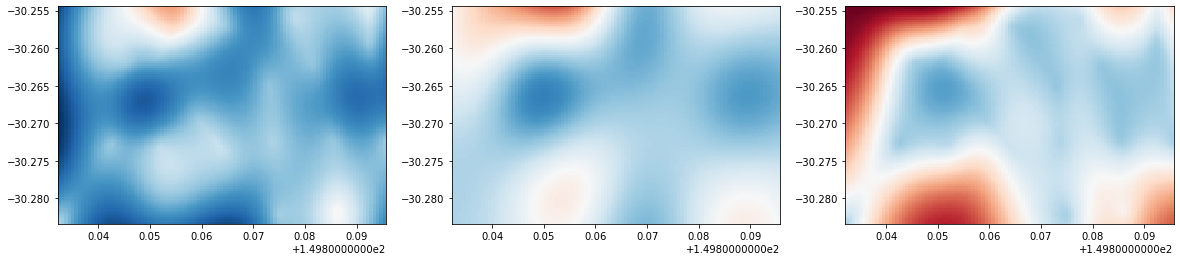

Initializing Model


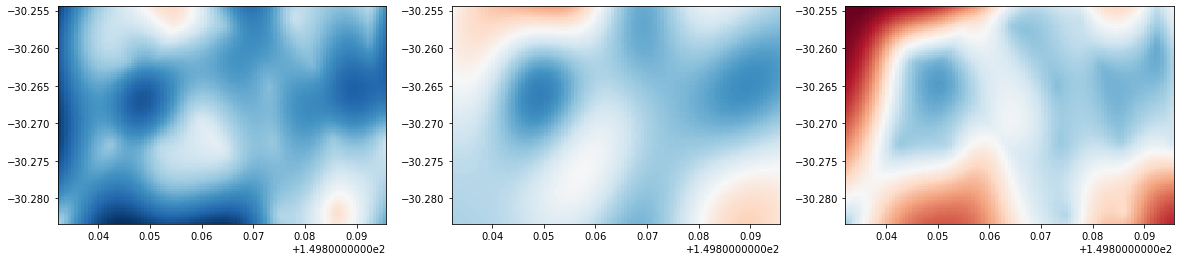

In [5]:
for i in range(3):
    single_frame_data = preprocessor.get_single_frame_data(ecoacoustic_data,i)
    SingleFrameGaussianProcessModel(single_frame_data).run()

<h2> III. Visualizing </h2>
<a id="visualise"></a>

<h3>a) The Visualise Class</h3>


In [6]:
class Visualise:
    def __init__(self,ecoacustic_data,metadata):
        self.ecoacoustic_data = ecoacoustic_data
        self.metadata = metadata.set_index('instrument_name')
        self.names = list(self.ecoacoustic_data.columns)
        
    def plot_all_ts(self):
        for name in self.names:
            plt.figure(figsize=(15, 3))
            plt.plot(self.ecoacoustic_data[name].values)
            plt.title(name)
            plt.show()
    
    def point_animation(self):    
        fig,ax = plt.subplots()

        lats = []
        longs = []
        for name in self.names:
            lats.append(self.metadata['latitude'][name])
            longs.append(self.metadata['longitude'][name])

        scatter = ax.scatter(longs, lats,s=np.zeros(len(self.names)))

        def init():
            scatter.set_sizes(np.zeros(len(self.names)))
            return scatter

        def update(frame):
            data = frame
            scatter.set_sizes(data*100)
            return scatter

        anim = FuncAnimation(fig, update, interval=1,frames = self.ecoacoustic_data.values,init_func=init)
        
        filename = 'results/animations/animation_of_' + str(len(self.names)) + '_plots.gif'
        anim.save(filename)


In [7]:
# visualiser = Visualise(ecoacoustic_data,metadata)
# visualiser.plot_all_ts()
# visualiser.point_animation()